# Access ERA5 data from NCAR's GDEX

In [1]:
# Imports
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake_esm
import glob
import pandas as pd
import os

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
# Set up your sratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)

/glade/derecho/scratch/harshah


In [6]:
gdex_data    = '/gdex/data/'
#
era5_posix     = 'https://osdf-director.osg-htc.org/ncar/gdex/d633000/catalogs/d633000-posix.json'
era5_https_url = 'https://osdf-director.osg-htc.org/ncar/gdex/d633000/catalogs/d633000-http.json'
era5_osdf_url  = 'https://osdf-director.osg-htc.org/ncar/gdex/d633000/catalogs/d633000-osdf.json'

### Create PBS cluster and scale

In [4]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = glade_scratch+'/dask/',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '5:00:00',
    log_directory = glade_scratch+'/dask/',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39563 instead
  warnings.warn(


In [5]:
cluster.scale(3)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/39563/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.99:39701,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/39563/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Open catalog and load data

### Direct POSIX access for NCAR's HPC users

In [7]:
cat = intake.open_esm_datastore(era5_posix)
cat

,unique
path,482
variable,210
format,2
short_name,210
long_name,210
units,33
start_time,9
end_time,10
level,0
level_units,0


In [8]:
cat.df

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/gdex/data/d633000/...,VAR_100U,zarr,100u,100 metre U wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
1,/glade/campaign/collections/gdex/data/d633000/...,VAR_100V,zarr,100v,100 metre V wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
2,/glade/campaign/collections/gdex/data/d633000/...,VAR_10U,zarr,10u,10 metre U wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
3,/glade/campaign/collections/gdex/data/d633000/...,VAR_10V,zarr,10v,10 metre V wind component,m s**-1,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
4,/glade/campaign/collections/gdex/data/d633000/...,VAR_2D,zarr,2d,2 metre dewpoint temperature,K,1940-01-01T00:00:00.000000000,2025-06-30T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
...,...,...,...,...,...,...,...,...,...,...,...
503,/glade/campaign/collections/gdex/data/d633000/...,VO,reference,vo,Vorticity (relative),s**-1,2000-01-01T00:00:00.000000000,2009-12-31T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
504,/glade/campaign/collections/gdex/data/d633000/...,VO,reference,vo,Vorticity (relative),s**-1,2010-01-01T00:00:00.000000000,2019-12-31T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
505,/glade/campaign/collections/gdex/data/d633000/...,VO,reference,vo,Vorticity (relative),s**-1,2010-01-01T00:00:00.000000000,2019-12-31T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds
506,/glade/campaign/collections/gdex/data/d633000/...,VO,reference,vo,Vorticity (relative),s**-1,2020-01-01T00:00:00.000000000,2024-06-30T23:00:00.000000000,NaN,NaN,3600000000000 nanoseconds


In [11]:
cat_temp = cat.search(variable='VAR_2T')

In [13]:
cat_temp.df['path'].values

array(['/glade/campaign/collections/gdex/data/d633000/e5.oper.an.sfc.zarr/e5.oper.an.sfc.2t.zarr'],
      dtype=object)

In [14]:
dsets = cat_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


In [15]:
dsets.keys()

dict_keys(['VAR_2T.2t'])

In [17]:
temp_posix = dsets['VAR_2T.2t']
temp_posix

<xarray.Dataset> Size: 3TB
Dimensions:            (time: 749472, latitude: 721, longitude: 1440)
Coordinates:
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * time               (time) datetime64[ns] 6MB 1940-01-01 ... 2025-06-30T23...
Data variables:
    VAR_2T             (time, latitude, longitude) float32 3TB dask.array<chunksize=(27, 480, 241), meta=np.ndarray>
    quantization_info  |S1 1B ...
    utc_date           (time) int32 3MB dask.array<chunksize=(27,), meta=np.ndarray>
Attributes: (12/20)
    CONVERSION_DATE:                 Mon 01 Sep 2025 04:08:47 PM MDT
    CONVERSION_PLATFORM:             Linux crhtc71 5.14.21-150400.24.46-defau...
    Conventions:                     CF-1.6
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NCO:                             netCDF Operators version 5.3.1 (Homepage...
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    ...                              ...
    intake_esm_attrs:long_name:      2 metre temperature
    intake_esm_attrs:units:          K
    intake_esm_attrs:start_time:     1940-01-01T00:00:00.000000000
    intake_esm_attrs:end_time:       2025-06-30T23:00:00.000000000
    intake_esm_attrs:frequency:      3600000000000 nanoseconds
    intake_esm_dataset_key:          VAR_2T.2t

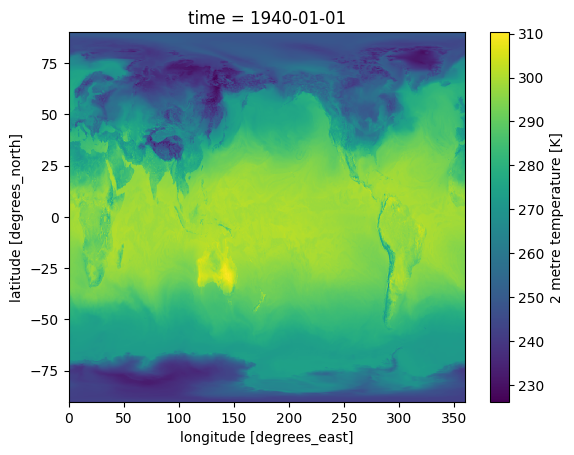

In [18]:
temp_posix.VAR_2T.isel(time=0).plot()

### Using HTTPS

In [22]:
catalog_https  = intake.open_esm_datastore(era5_https_url)
cat_temp_https = catalog_https.search(variable='VAR_2T')

In [24]:
cat_temp_https.df['path'].values

array(['https://data.gdex.ucar.edu/d633000/e5.oper.an.sfc.zarr/e5.oper.an.sfc.2t.zarr'],
      dtype=object)

In [29]:
dsets_https = cat_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


ESMDataSourceError: Failed to load dataset with key='VAR_2T.2t'
                 You can use `cat['VAR_2T.2t'].df` to inspect the assets/files for this key.
                 

In [ ]:
temp_https = dsets_https['VAR_2T.2t']

In [ ]:
temp_https.VAR_2T.isel(time=0).plot()

### Using OSDF

In [30]:
catalog_osdf  = intake.open_esm_datastore(era5_osdf_url)
cat_temp_osdf = catalog_osdf.search(variable='VAR_2T')

In [31]:
cat_temp_osdf.df['path'].values

array(['osdf:///ncar/gdex/d633000/e5.oper.an.sfc.zarr/e5.oper.an.sfc.2t.zarr'],
      dtype=object)

In [32]:
dsets_osdf = cat_temp_osdf.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


In [33]:
temp_osdf = dsets_osdf['VAR_2T.2t']

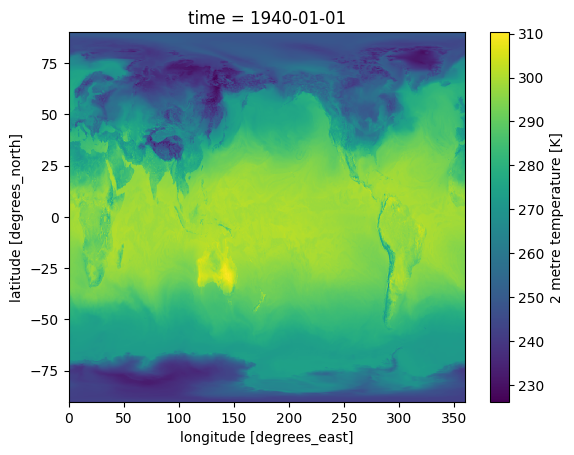

In [34]:
temp_osdf.VAR_2T.isel(time=0).plot()